In [29]:
import sqlite3
import statistics
import matplotlib.pyplot as plt

conn = sqlite3.connect('songs.db')

cursor = conn.cursor()

In [50]:


def calcMedianSentiment(year):
    medianLyricSentiment = {}
    cursor.execute(
        '''
        SELECT sampleID, country FROM sample
        WHERE year = ?;
        ''', (year,)
    )
    samples = cursor.fetchall()
    for sampleID, country in samples:
        if not country in medianLyricSentiment:
            medianLyricSentiment[country] = []
        
        cursor.execute(
            '''
            SELECT songID FROM sample_song
            WHERE sampleID = ?
            ''', (sampleID,)
        )
        songIDs = cursor.fetchall()
        for songID in songIDs:
            cursor.execute(
                '''
                SELECT lyric_sentiment FROM song
                WHERE songID = ?;
                ''', (songID)
            )
            lyric_sentiment = cursor.fetchone()
            if lyric_sentiment is not None and lyric_sentiment[0] is not None:
                medianLyricSentiment[country].append(lyric_sentiment[0])
    noneKeys = []
    for country in medianLyricSentiment:
        if len(medianLyricSentiment[country]):
            medianLyricSentiment[country] = statistics.median(medianLyricSentiment[country])
        else:
            noneKeys.append(country)
    for country in noneKeys:
        del medianLyricSentiment[country]
    return medianLyricSentiment

def getIndicatorDict(year, indicator):
    indicatorDict = {}
    cursor.execute(
        '''
        SELECT indicator_setID, country FROM sample
        WHERE year = ?;
        ''', (year,)
    )
    samples = cursor.fetchall()
    for indicator_setID, country in samples:
        if not country in indicatorDict:
            indicatorDict[country] = []
        cursor.execute(
            f'''
            SELECT {indicator} FROM indicator_set
            WHERE indicator_setID = ?
            ''', (indicator_setID,)
        )
        indicatorValue = cursor.fetchone()
        if indicatorValue is not None:
            indicatorDict[country].append(indicatorValue[0])
    noneKeys = []
    for country in indicatorDict:
        if len(indicatorDict[country]):
            indicatorDict[country] = statistics.median(indicatorDict[country])
        else:
            noneKeys.append(country)
    for country in noneKeys:
        del indicatorDict[country]
    return indicatorDict

def standardizeDict(dict):
    dictMin = min(dict.values())
    dictMax = max(dict.values())
    for country in dict:
        dict[country] = (dict[country] - dictMin) / (dictMax - dictMin)
    return dict


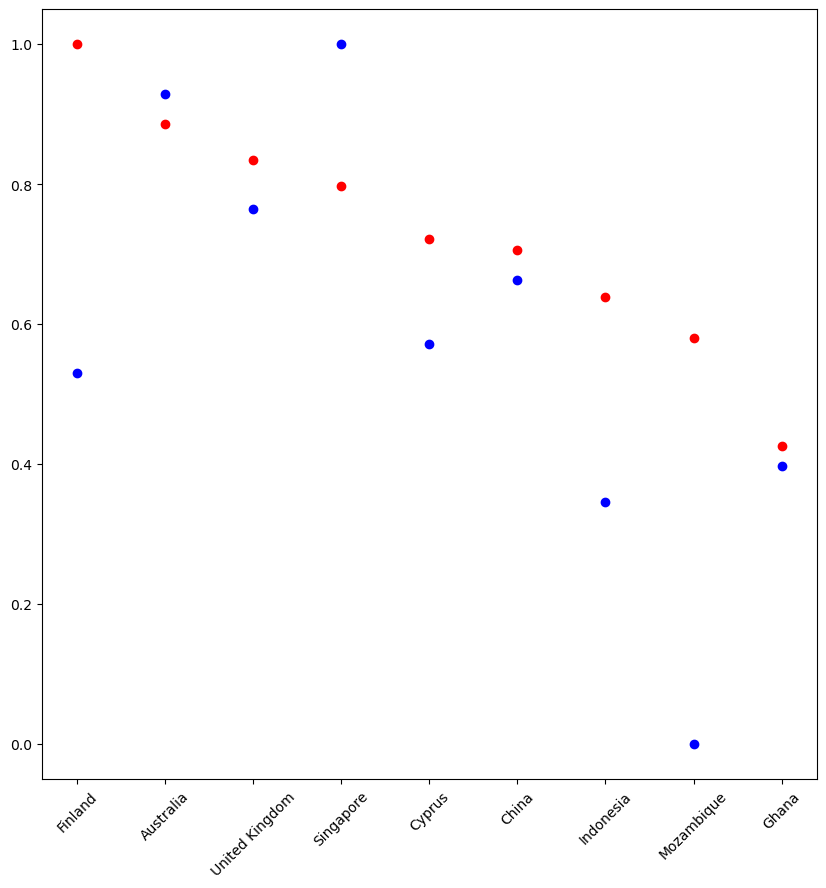

In [57]:
medianLyricSentiment = standardizeDict(calcMedianSentiment(2024))
happiness_index = standardizeDict(getIndicatorDict(2024, 'happiness_index'))
happiness_index = {k: happiness_index[k] for k in happiness_index if k in medianLyricSentiment}
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plt.xticks(rotation=45)
axs.scatter(medianLyricSentiment.keys(), medianLyricSentiment.values(), color='blue')
axs.scatter(happiness_index.keys(), happiness_index.values(), color='red')
plt.show()